In [17]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import joblib  # To save the model
from hyperopt import fmin, tpe, hp, Trials  # Import Hyperopt for TPE
from sklearn.linear_model import LinearRegression  # Import for stacking

# ============================
# Hyperparameter distributions for each target parameter
# ============================
param_dist_precipitation = {
    'n_estimators': hp.quniform('n_estimators', 500, 1200, 50),
    'max_depth': hp.choice('max_depth', [4, 5, 6, 7, 8, 9, 10, 11]),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 5),
    'max_bin': hp.quniform('max_bin', 20, 256, 5)
}

param_dist_soil_moisture = {
    'n_estimators': hp.quniform('n_estimators', 600, 1800, 50),
    'max_depth': hp.choice('max_depth', [4, 5, 6, 7, 8, 9, 10]),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 5),
    'max_bin': hp.quniform('max_bin', 20, 256, 5)
}

param_dist_windspeed = {
    'n_estimators': hp.quniform('n_estimators', 800, 2000, 50),
    'max_depth': hp.choice('max_depth', [4, 5, 6, 7, 8, 9, 10]),
    'min_child_weight': hp.quniform('min_child_weight', 0.1, 5, 0.1),
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 3),
    'max_bin': hp.quniform('max_bin', 100, 512, 10)

}
param_dist_surface_temp = {
    'n_estimators': hp.quniform('n_estimators', 600, 1800, 50),
    'max_depth': hp.choice('max_depth', [4, 5, 6, 7, 8, 9, 10, 11]),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 5),
    'max_bin': hp.quniform('max_bin', 20, 256, 5)
}

param_dist_deep_soil_temp = {
    'n_estimators': hp.quniform('n_estimators', 600, 1800, 50),
    'max_depth': hp.choice('max_depth', [4, 5, 6, 7, 8, 9, 10, 11]),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 5),
    'max_bin': hp.quniform('max_bin', 20, 256, 5)
}

param_dist_rf = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
    'max_depth': hp.choice('max_depth', [None, 5, 10, 15, 20]),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2'])  # Updated options
}

# Data Loading & Preprocessing
# ============================
try:
    df = pd.read_csv('sorted_data.csv')
except Exception as e:
    print(f"Error reading the CSV file: {e}")
    raise

# List of target columns
columns_to_predict = [
    'PRECIPITATION RATE', 'SOIL MOISTURE', 'WIND SPEED',
    'SURFACE TEMPERATURE', 'DEEP SOIL TEMPERATURE'
]

# Feature Engineering: Adding temporal and trigonometric features
df['SEASON'] = (df['MONTH'] % 12 + 3) // 3
df['SIN_MONTH'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['COS_MONTH'] = np.cos(2 * np.pi * df['MONTH'] / 12)

# Function to create lag features for a given column
def create_lag_features(df, column):
    df[f'{column}_LAG1'] = df[column].shift(1)
    df[f'{column}_LAG2'] = df[column].shift(2)

# Create lag features for each target column
for column in columns_to_predict:
    create_lag_features(df, column)

# Rolling Mean Features for all five parameters
for column in columns_to_predict:
    df[f'{column}_ROLLING_MEAN'] = df[column].rolling(window=3).mean()

# Metadata columns (numeric only)
metadata_columns = ['YEAR', 'MONTH', 'AVRG ELEVATION', 'MIN ELEVATION', 'MAX ELEVATION']

# Engineered features from time series
engineered_features = [
    'SEASON', 'SIN_MONTH', 'COS_MONTH',
    'PRECIPITATION RATE_LAG1', 'PRECIPITATION RATE_LAG2', 'PRECIPITATION RATE_ROLLING_MEAN',
    'SOIL MOISTURE_LAG1', 'SOIL MOISTURE_LAG2', 'SOIL MOISTURE_ROLLING_MEAN',
    'WIND SPEED_LAG1', 'WIND SPEED_LAG2', 'WIND SPEED_ROLLING_MEAN',
    'SURFACE TEMPERATURE_LAG1', 'SURFACE TEMPERATURE_LAG2', 'SURFACE TEMPERATURE_ROLLING_MEAN',
    'DEEP SOIL TEMPERATURE_LAG1', 'DEEP SOIL TEMPERATURE_LAG2', 'DEEP SOIL TEMPERATURE_ROLLING_MEAN'
]

# Combine engineered features with metadata to form the final feature set
feature_columns = engineered_features + metadata_columns

# Handle missing values for engineered features and metadata
imputer = KNNImputer(n_neighbors=5)
df[engineered_features] = imputer.fit_transform(df[engineered_features])
df[metadata_columns] = imputer.fit_transform(df[metadata_columns])

# (Optional) Scale engineered features
scaler = StandardScaler()
df[engineered_features] = scaler.fit_transform(df[engineered_features])

# Function to remove outliers using the IQR method
def remove_outliers(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Outlier thresholds for each target column
outlier_thresholds = {
    'DEEP SOIL TEMPERATURE': 1.5,
    'SOIL MOISTURE': 2.0,
    'PRECIPITATION RATE': 3.0,
    'WIND SPEED': 3.0,
    'SURFACE TEMPERATURE': 1.8
}

# Remove outliers for each target variable
for column, threshold in outlier_thresholds.items():
    df = remove_outliers(df, column, threshold)
    print(f"Outliers removed from {column} with threshold {threshold}")

# ============================
# Model Training for Each Target
# ============================
for column in columns_to_predict:
    print(f"\n🔹 Training model for {column}...")

    # Prepare features and target
    X = df[feature_columns]
    y = df[column]

    # --- Modifications for PRECIPITATION RATE only ---
    if column == 'PRECIPITATION RATE':
        orig_index = y.index.copy()
        epsilon = 1e-3
        y = y.replace(0, epsilon)
        if (y > 0).all():
            y_transformed, lambda_val = boxcox(y)
            y = pd.Series(y_transformed, index=orig_index)
            transformation_used = 'boxcox'
        else:
            y_transformed = np.log1p(y)
            y = pd.Series(y_transformed, index=orig_index)
            transformation_used = 'log'
            lambda_val = None
    # -----------------------------------------------

    # Remove rows with missing target values
    X = X[~y.isnull()]
    y = y.dropna()

    # Split data into train/validation (80%) and test (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )

    # Further split training data (80/20 split)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=42, shuffle=False
    )

    # ========================================
    # Hyperparameter Tuning with TPE for XGBoost
    # ========================================
    
    def objective_func_xgb(params):
        model = XGBRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']) if params['max_depth'] is not None else None,
            min_child_weight=int(params['min_child_weight']),
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            gamma=params['gamma'],
            reg_alpha=params['reg_alpha'],
            reg_lambda=params['reg_lambda'],
            random_state=42
        )
        
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        
        return -np.mean(cv_scores)  # Return negative score for minimization

    # Define the search space for hyperparameters for XGBoost
    space_xgb = param_dist_precipitation  # Use the specific distribution for precipitation

    # Create a Trials object to keep track of evaluations
    trials_xgb = Trials()

    # Run the optimization for XGBoost
    best_xgb = fmin(fn=objective_func_xgb, space=space_xgb, algo=tpe.suggest, max_evals=50, trials=trials_xgb)

   # Retrieve the best parameters for Random Forest
    best_params_rf = {
        'n_estimators': int(best_rf['n_estimators']),
        'max_depth': int(best_rf['max_depth']) if best_rf['max_depth'] is not None else None,
        'min_samples_split': int(best_rf['min_samples_split']),
        'min_samples_leaf': int(best_rf['min_samples_leaf']),
        'max_features': best_rf['max_features'] if best_rf['max_features'] is not None else 'sqrt'  # Default to 'sqrt' if None
    }
    
    # Ensure max_depth is valid
    if best_params_rf['max_depth'] == 0:
        best_params_rf['max_depth'] = None  # Set to None if invalid
    
    # Ensure max_features is valid
    if best_params_rf['max_features'] == 0:
        best_params_rf['max_features'] = 'sqrt'  # Set to 'sqrt' if invalid
    
    # Check if max_features is still invalid
    if best_params_rf['max_features'] not in [None, 'sqrt', 'log2']:
        raise ValueError(f"Invalid value for max_features: {best_params_rf['max_features']}. Must be None, 'sqrt', 'log2', or an integer > 0.")
    
    print(f"✅ Best hyperparameters for Random Forest for {column} found via TPE: {best_params_rf}")
    
    # Train the final Random Forest model using the best hyperparameters on X_train
    final_rf = RandomForestRegressor(random_state=42, **best_params_rf)
    final_rf.fit(X_train, y_train)

    print(f"✅ Best hyperparameters for XGBoost for {column} found via TPE: {best_params_xgb}")
    
    # Train the final XGBoost model using the best hyperparameters on X_train
    final_xgb = XGBRegressor(random_state=42, **best_params_xgb)
    final_xgb.fit(X_train, y_train)

    # ========================================
    # Hyperparameter Tuning with TPE for Random Forest
    # ========================================
    # ========================================
    # Hyperparameter Tuning with TPE for Random Forest
    # ========================================
    
    def objective_func_rf(params):
        model = RandomForestRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']) if params['max_depth'] is not None else None,
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            max_features=params['max_features'],
            random_state=42
        )
        
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        
        return -np.mean(cv_scores)  # Return negative score for minimization
    
    # Define the search space for hyperparameters for Random Forest
    space_rf = param_dist_rf
    
    # Create a Trials object to keep track of evaluations
    trials_rf = Trials()
    
    # Run the optimization for Random Forest
    best_rf = fmin(fn=objective_func_rf, space=space_rf, algo=tpe.suggest, max_evals=50, trials=trials_rf)
    
    # Retrieve the best parameters for Random Forest
    best_params_rf = {
        'n_estimators': int(best_rf['n_estimators']),
        'max_depth': int(best_rf['max_depth']) if best_rf['max_depth'] is not None else None,
        'min_samples_split': int(best_rf['min_samples_split']),
        'min_samples_leaf': int(best_rf['min_samples_leaf']),
        'max_features': best_rf['max_features'] if best_rf['max_features'] is not None else 'sqrt'  # Default to 'sqrt' if None
    }
    
    # Ensure max_depth is valid
    if best_params_rf['max_depth'] == 0:
        best_params_rf['max_depth'] = None  # Set to None if invalid
    
    # Ensure max_features is valid
    if best_params_rf['max_features'] == 0:
        best_params_rf['max_features'] = 'sqrt'  # Set to 'sqrt' if invalid
    
    # Check if max_features is still invalid
    if best_params_rf['max_features'] not in [None, 'sqrt', 'log2']:
        raise ValueError(f"Invalid value for max_features: {best_params_rf['max_features']}. Must be None, 'sqrt', 'log2', or an integer > 0.")
    
    print(f"✅ Best hyperparameters for Random Forest for {column} found via TPE: {best_params_rf}")
    
    # Train the final Random Forest model using the best hyperparameters on X_train
    final_rf = RandomForestRegressor(random_state=42, **best_params_rf)
    final_rf.fit(X_train, y_train)

    # Make predictions on the validation set with both models
    y_pred_xgb_val = final_xgb.predict(X_val)
    y_pred_rf_val = final_rf.predict(X_val)

    # Create a new DataFrame for the stacking model
    stacking_data = pd.DataFrame({
        'XGBoost_Prediction': y_pred_xgb_val,
        'RandomForest_Prediction': y_pred_rf_val,
        'Actual': y_val
    })

    # Train a stacking model (e.g., Linear Regression)
    stacking_model = LinearRegression()
    stacking_model.fit(stacking_data[['XGBoost_Prediction', 'RandomForest_Prediction']], stacking_data['Actual'])

    # Make predictions on the test set with both models
    y_pred_xgb_test = final_xgb.predict(X_test)
    y_pred_rf_test = final_rf.predict(X_test)

    # Create a new DataFrame for the test set predictions
    stacking_test_data = pd.DataFrame({
        'XGBoost_Prediction': y_pred_xgb_test,
        'RandomForest_Prediction': y_pred_rf_test
    })

    # Use the stacking model to make final predictions
    y_pred_stacked = stacking_model.predict(stacking_test_data)

    # --- Reverse transformation for PRECIPITATION RATE ---
    if column == 'PRECIPITATION RATE':
        if transformation_used == 'boxcox':
            y_pred_stacked = inv_boxcox(y_pred_stacked, lambda_val)
            y_test = inv_boxcox(y_test, lambda_val)
        else:  # transformation_used == 'log'
            y_pred_stacked = np.expm1(y_pred_stacked)
            y_test = np.expm1(y_test)
    # ---------------------------------------------------

    # Calculate performance metrics for the stacked model
    mse_stacked = mean_squared_error(y_test, y_pred_stacked)
    rmse_stacked = np.sqrt(mse_stacked)
    mae_stacked = mean_absolute_error(y_test, y_pred_stacked)

    # --- Adjust MAPE calculation for PRECIPITATION RATE ---
    if column == 'PRECIPITATION RATE':
        threshold = 0.1  # Minimum value threshold for the denominator
        denom = np.where(np.abs(y_test) < threshold, threshold, y_test)
        mape_stacked = np.mean(np.abs((y_test - y_pred_stacked) / denom)) * 100
    else:
        mape_stacked = np.mean(np.abs((y_test - y_pred_stacked) / (y_test + 1e-5))) * 100
    # --------------------------------------------------

    r2_stacked = r2_score(y_test, y_pred_stacked)

    print(f"\n📊 Metrics for {column} (Stacked Model):")
    print(f"  🔹 Mean Absolute Percentage Error (MAPE): {mape_stacked:.2f}%")
    print(f"  🔹 Mean Squared Error (MSE): {mse_stacked:.4f}")
    print(f"  🔹 Root Mean Squared Error (RMSE): {rmse_stacked:.4f}")
    print(f"  🔹 Mean Absolute Error (MAE): {mae_stacked:.4f}")
    print(f"  🔹 R-squared (R²): {r2_stacked:.2f}")
    overall_accuracy_stacked = 100 - mape_stacked
    print(f"  ✅ Overall Accuracy: {overall_accuracy_stacked:.2f}%")
    print(f"  ✅ Overall Accuracy (R²): {r2_stacked * 100:.2f}%")

    # Save predictions along with metadata for traceability
    predictions_stacked = pd.DataFrame({
        'YEAR': df.loc[X_test.index, 'YEAR'],
        'MONTH': df.loc[X_test.index, 'MONTH'],
        'NAME': df.loc[X_test.index, 'NAME'],
        'AVRG ELEVATION': df.loc[X_test.index, 'AVRG ELEVATION'],
        'MIN ELEVATION': df.loc[X_test.index, 'MIN ELEVATION'],
        'MAX ELEVATION': df.loc[X_test.index, 'MAX ELEVATION'],
        'ACTUAL VALUE': df.loc[X_test.index, column],
        'PREDICTED VALUE (Stacked)': y_pred_stacked
    })

    output_file_stacked = f'{column.replace(" ", "_")}_stacked_predictions.csv'
    predictions_stacked.to_csv(output_file_stacked, index=False)
    print(f"📂 Stacked predictions saved to {output_file_stacked}")

    # Save the trained models
    joblib.dump(final_xgb, f'final_xgb_model_{column.replace(" ", "_")}.joblib')
    joblib.dump(final_rf, f'final_rf_model_{column.replace(" ", "_")}.joblib')
    print(f"✅ Models saved for {column}.")

Outliers removed from DEEP SOIL TEMPERATURE with threshold 1.5
Outliers removed from SOIL MOISTURE with threshold 2.0
Outliers removed from PRECIPITATION RATE with threshold 3.0
Outliers removed from WIND SPEED with threshold 3.0
Outliers removed from SURFACE TEMPERATURE with threshold 1.8

🔹 Training model for PRECIPITATION RATE...
100%|███████████████████████████████████████████████| 50/50 [01:51<00:00,  2.22s/trial, best loss: -0.9746168582685337]


NameError: name 'best_rf' is not defined

Metrics for PRECIPITATION_RATE_stacked_predictions.csv:
  Mean Absolute Error (MAE): 0.0224
  Mean Squared Error (MSE): 0.0016
  Root Mean Squared Error (RMSE): 0.0401
  R-squared (R²): 0.9607


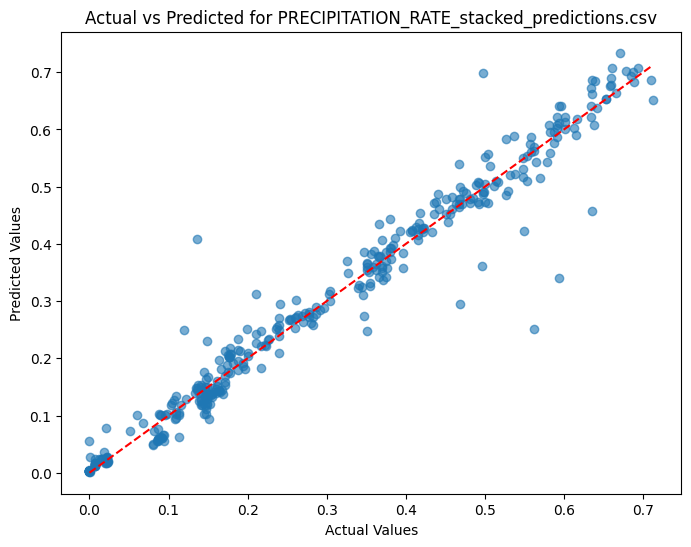

Metrics for SOIL_MOISTURE_stacked_predictions.csv:
  Mean Absolute Error (MAE): 0.0242
  Mean Squared Error (MSE): 0.0012
  Root Mean Squared Error (RMSE): 0.0348
  R-squared (R²): 0.9744


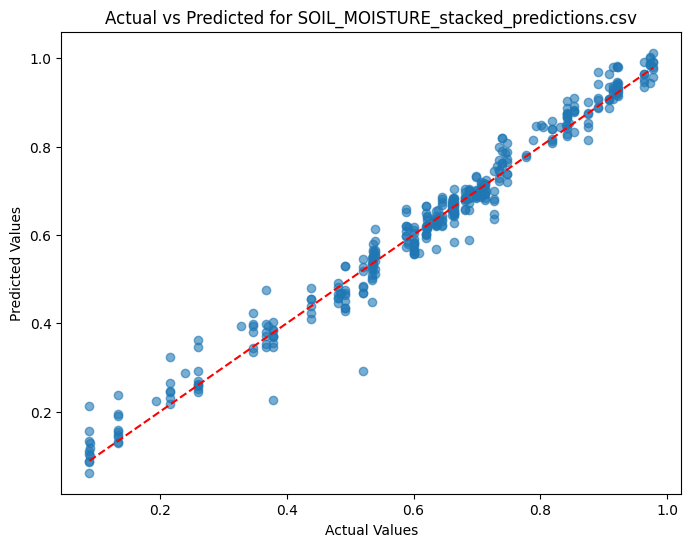

Metrics for WIND_SPEED_stacked_predictions.csv:
  Mean Absolute Error (MAE): 0.0330
  Mean Squared Error (MSE): 0.0020
  Root Mean Squared Error (RMSE): 0.0447
  R-squared (R²): 0.9623


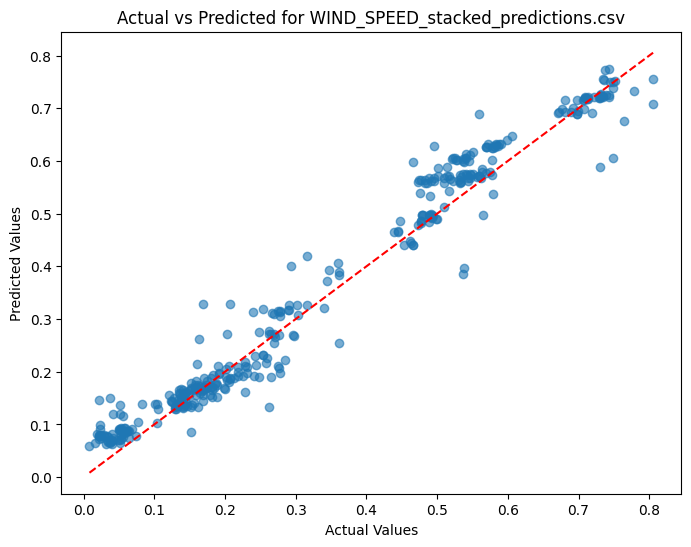

Metrics for SURFACE_TEMPERATURE_stacked_predictions.csv:
  Mean Absolute Error (MAE): 0.0236
  Mean Squared Error (MSE): 0.0011
  Root Mean Squared Error (RMSE): 0.0334
  R-squared (R²): 0.9358


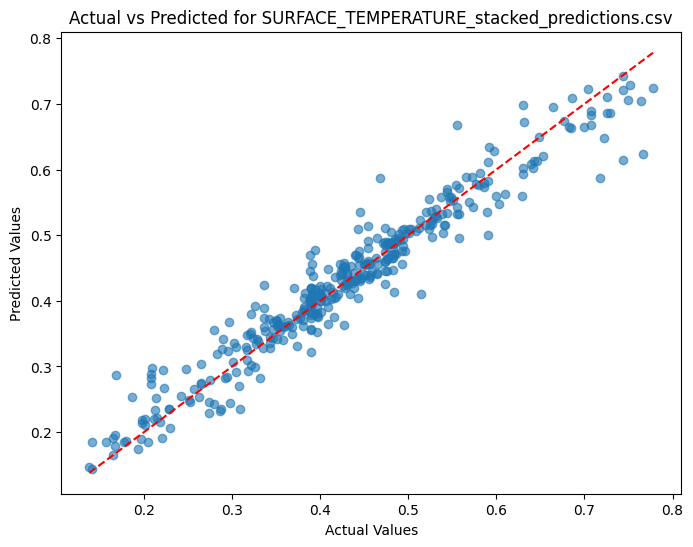

Metrics for DEEP_SOIL_TEMPERATURE_stacked_predictions.csv:
  Mean Absolute Error (MAE): 0.0214
  Mean Squared Error (MSE): 0.0009
  Root Mean Squared Error (RMSE): 0.0300
  R-squared (R²): 0.9550


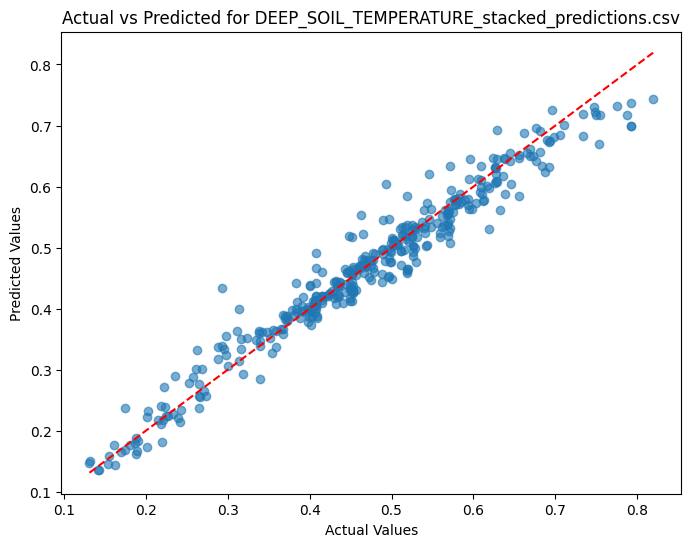

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(predicted_file, actual_col, predicted_col):
    # Load actual and predicted values from CSV
    df = pd.read_csv(predicted_file)  # Load the CSV file
    y_true = df[actual_col]   # Actual label column name
    y_pred = df[predicted_col]  # Predicted label column name

    # Calculate regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Print regression metrics
    print(f"Metrics for {predicted_file}:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")

    # Optionally, you can visualize the predictions vs actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Line for perfect predictions
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted for {predicted_file}")
    plt.savefig(f"{predicted_file.replace('.csv', '_actual_vs_predicted.png')}")  # Save the plot as an image
    plt.show()

# List of files to evaluate
files_to_evaluate = [
    "PRECIPITATION_RATE_stacked_predictions.csv",
    "SOIL_MOISTURE_stacked_predictions.csv",
    "WIND_SPEED_stacked_predictions.csv",
    "SURFACE_TEMPERATURE_stacked_predictions.csv",
    "DEEP_SOIL_TEMPERATURE_stacked_predictions.csv"
]

# Define the actual and predicted column names
actual_col_name = "ACTUAL VALUE"
predicted_col_name = "PREDICTED VALUE (Stacked)"

# Loop through each file and evaluate
for file in files_to_evaluate:
    evaluate_model(file, actual_col_name, predicted_col_name)  # Use the actual column names

Columns in PRECIPITATION_RATE_stacked_predictions.csv: ['YEAR', 'MONTH', 'NAME', 'AVRG ELEVATION', 'MIN ELEVATION', 'MAX ELEVATION', 'ACTUAL VALUE', 'PREDICTED VALUE (Stacked)']
Columns in SOIL_MOISTURE_stacked_predictions.csv: ['YEAR', 'MONTH', 'NAME', 'AVRG ELEVATION', 'MIN ELEVATION', 'MAX ELEVATION', 'ACTUAL VALUE', 'PREDICTED VALUE (Stacked)']
Columns in WIND_SPEED_stacked_predictions.csv: ['YEAR', 'MONTH', 'NAME', 'AVRG ELEVATION', 'MIN ELEVATION', 'MAX ELEVATION', 'ACTUAL VALUE', 'PREDICTED VALUE (Stacked)']
Columns in SURFACE_TEMPERATURE_stacked_predictions.csv: ['YEAR', 'MONTH', 'NAME', 'AVRG ELEVATION', 'MIN ELEVATION', 'MAX ELEVATION', 'ACTUAL VALUE', 'PREDICTED VALUE (Stacked)']
Columns in DEEP_SOIL_TEMPERATURE_stacked_predictions.csv: ['YEAR', 'MONTH', 'NAME', 'AVRG ELEVATION', 'MIN ELEVATION', 'MAX ELEVATION', 'ACTUAL VALUE', 'PREDICTED VALUE (Stacked)']


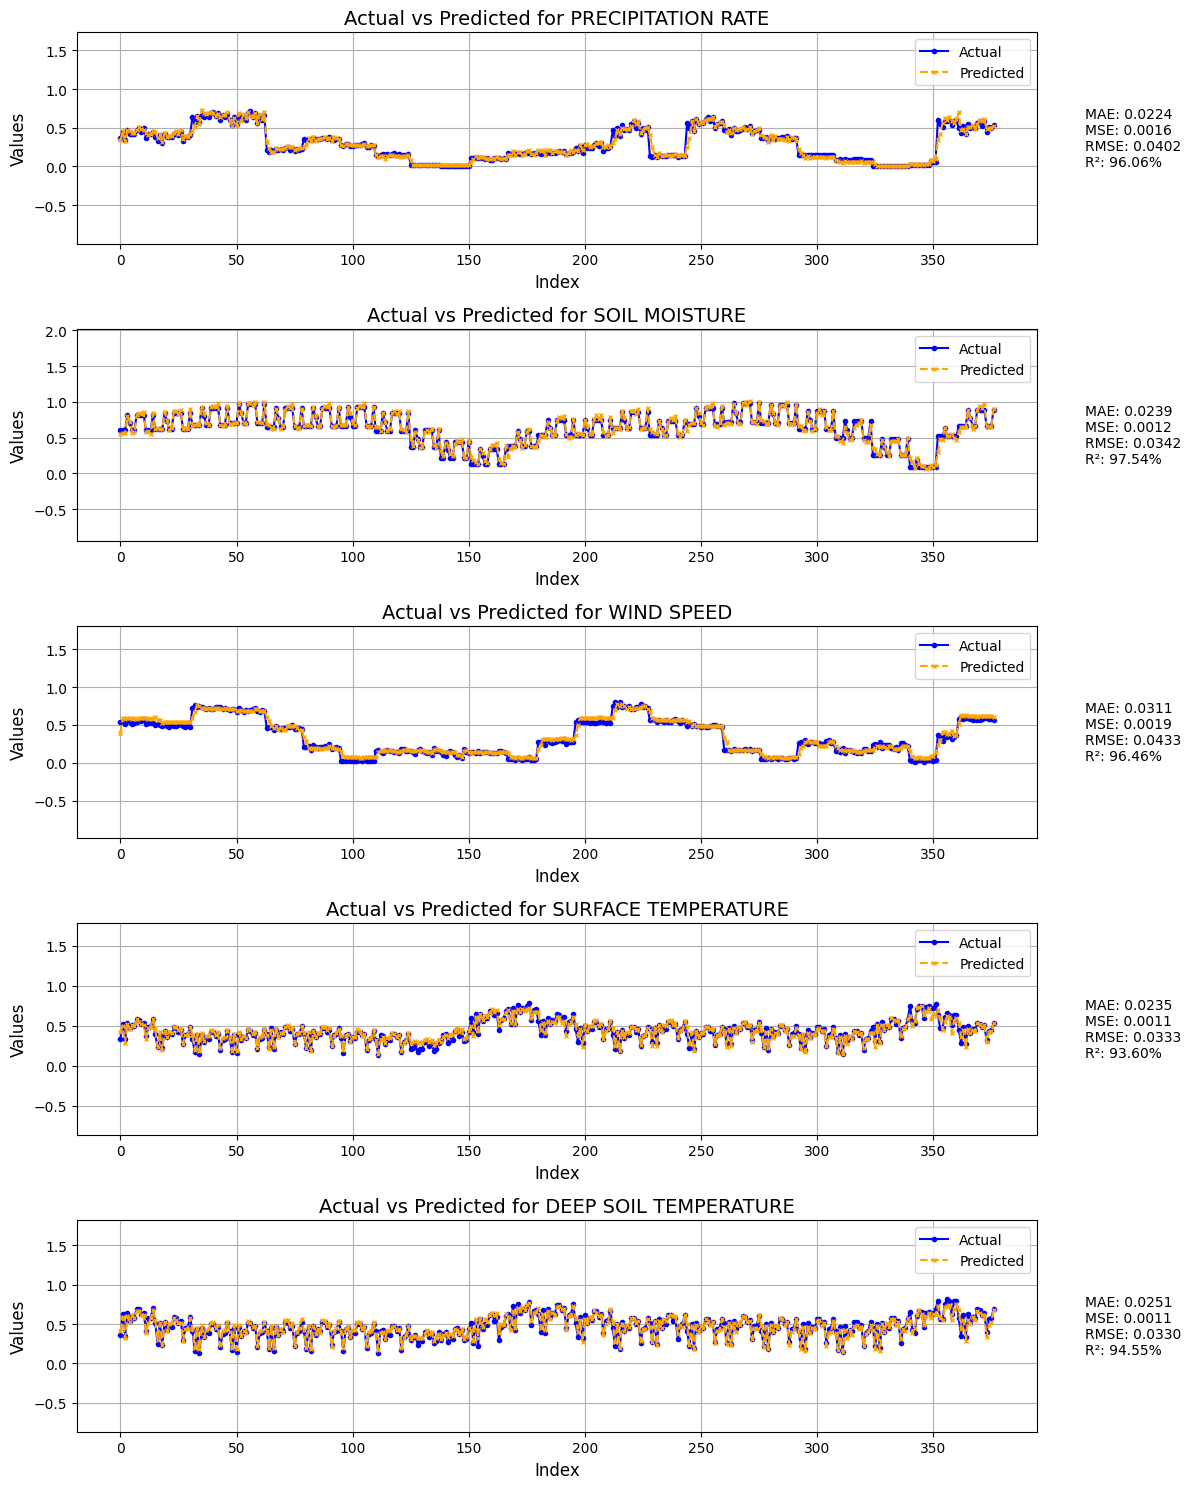

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# List of target columns
columns_to_predict = [
    'PRECIPITATION RATE', 'SOIL MOISTURE', 'WIND SPEED',
    'SURFACE TEMPERATURE', 'DEEP SOIL TEMPERATURE'
]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=len(columns_to_predict), ncols=1, figsize=(12, 15))

# Loop through each parameter to read the corresponding CSV file and plot
for ax, column in zip(axes, columns_to_predict):
    # Construct the filename
    output_file = f'{column.replace(" ", "_")}_stacked_predictions.csv'
    
    try:
        # Read the CSV file
        data = pd.read_csv(output_file)
        
        # Print the columns for debugging
        print(f"Columns in {output_file}: {data.columns.tolist()}")
        
        # Plot actual vs predicted values
        ax.plot(data['ACTUAL VALUE'], label='Actual', color='blue', linestyle='-', marker='o', markersize=3)
        ax.plot(data['PREDICTED VALUE (Stacked)'], label='Predicted', color='orange', linestyle='--', marker='x', markersize=3)
        
        # Set title and labels
        ax.set_title(f'Actual vs Predicted for {column}', fontsize=14)
        ax.set_xlabel('Index', fontsize=12)
        ax.set_ylabel('Values', fontsize=12)
        ax.legend()
        ax.grid()
        
        # Set dynamic y-axis limits
        ax.set_ylim([data[['ACTUAL VALUE', 'PREDICTED VALUE (Stacked)']].min().min() - 1,
                      data[['ACTUAL VALUE', 'PREDICTED VALUE (Stacked)']].max().max() + 1])

        # Calculate accuracy metrics
        mae = mean_absolute_error(data['ACTUAL VALUE'], data['PREDICTED VALUE (Stacked)'])
        mse = mean_squared_error(data['ACTUAL VALUE'], data['PREDICTED VALUE (Stacked)'])
        rmse = mse ** 0.5
        r2 = r2_score(data['ACTUAL VALUE'], data['PREDICTED VALUE (Stacked)'])

        # Print metrics beside the plot
        metrics_text = (f'MAE: {mae:.4f}\n'
                        f'MSE: {mse:.4f}\n'
                        f'RMSE: {rmse:.4f}\n'
                        f'R²: {r2 * 100:.2f}%')  # Format R² as a percentage
        
        # Display the metrics text beside the plot
        ax.text(1.05, 0.5, metrics_text, ha='left', va='center', fontsize=10, transform=ax.transAxes)

    except FileNotFoundError:
        print(f"Error: The file {output_file} was not found.")
    except KeyError as e:
        print(f"Error: Missing column in {output_file}: {e}")

# Adjust layout to provide more space for the text
plt.tight_layout()

# Save the plot as an image file (optional)
plt.savefig("actual_vs_predicted_plot.png")

# Show the plot
plt.show()